# Problema de clasificación: Accidentes de coches en Canada 

Como hemos dicho en la primera parte, lo complicado en este dataset es que tenemos observaciones para cada persona del accidente. Es decir, para cada accidente con 6 personas implicadas tenemos 6 observaciones duplicadas del accidente. Tener observaciones duplicadas del accidente puede generar overfitting y confundir al modelo.

La solucion que proponemos es filtrar el dataset solo para los conductores y peatones.
Ademas, desde el punto de vista de una aseguradora, este es un problema mas realista ya que solo tendria datos del asegurado.


# Librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import matplotlib.pyplot as plt


import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

# Carga de datos

Una vez cargados los datos, le vamos a cambiar el nombre a las variables para que sea mas facil interpretarlas y transformatemos la variable fatality : 0 sigifica no mortal y 1 mortal  

In [2]:
df= pd.read_csv('NCDB_1999_to_2014.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [3]:
print(df.shape)

(5860405, 22)


In [4]:
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

df.columns = new_names

In [5]:
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality

df['fatality'] = df['fatality'].replace({2:0})

#Ponemos la variable objetivo a la derecha del dataframe
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])
df = df[new_columns]
df.head()

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,...,vehicle_type,vehicle_year,passenger_id,passenger_sex,passenger_age,passenger_role,passenger_fatality,passenger_safety,passenger_type,fatality
0,1999,1,1,20,02,34,UU,1,5,3,...,06,1990,01,M,41,11,1,UU,1,0
1,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,01,M,19,11,1,UU,1,0
2,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,02,F,20,13,2,02,2,0
3,1999,1,1,08,01,01,UU,5,3,6,...,01,1986,01,M,46,11,1,UU,1,0
4,1999,1,1,08,01,01,UU,5,3,6,...,NN,NNNN,01,M,05,99,2,UU,3,0


# Eliminación de datos duplicados

In [6]:
print("Cantidad de duplicados:", df.duplicated().sum())

Cantidad de duplicados: 5069


In [7]:
df = df.drop_duplicates()
df.head()

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,...,vehicle_type,vehicle_year,passenger_id,passenger_sex,passenger_age,passenger_role,passenger_fatality,passenger_safety,passenger_type,fatality
0,1999,1,1,20,02,34,UU,1,5,3,...,06,1990,01,M,41,11,1,UU,1,0
1,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,01,M,19,11,1,UU,1,0
2,1999,1,1,20,02,34,UU,1,5,3,...,01,1987,02,F,20,13,2,02,2,0
3,1999,1,1,08,01,01,UU,5,3,6,...,01,1986,01,M,46,11,1,UU,1,0
4,1999,1,1,08,01,01,UU,5,3,6,...,NN,NNNN,01,M,05,99,2,UU,3,0


# Tranformacion variable --> edad del coche

In [8]:
# Transformamos la variable vehicle_year a años de antigüedad 
df['vehicle_year'] = pd.to_numeric(df.year - pd.to_numeric(df.vehicle_year, errors= "coerce"))
df = df.rename(columns={"vehicle_year": 'vehicle_age'})

In [9]:
df['vehicle_age'].unique()

array([  9.,  12.,  13.,  nan,  15.,   8.,   7.,   2.,   6.,  14.,  11.,
         5.,   4.,   1.,  10.,   3.,  16.,   0.,  34.,  22.,  21.,  31.,
        18.,  20.,  23.,  27.,  -1.,  17.,  24.,  26.,  25.,  19.,  32.,
        29.,  28.,  37.,  30.,  33.,  54.,  36.,  39.,  49.,  35.,  40.,
        44.,  41.,  96.,  90.,  50.,  76.,  38.,  85.,  91.,  46.,  93.,
        60.,  74.,  51.,  61.,  92.,  47.,  95.,  82.,  87.,  55.,  43.,
        69.,  68.,  48.,  53.,  52.,  42.,  45.,  56.,  98.,  62.,  94.,
        64.,  73.,  58.,  67.,  79.,  66.,  80.,  84.,  70.,  71.,  83.,
        86.,  75.,  -2.,  59.,  65.,  63.,  77.,  72.,  81.,  57., 100.,
        99., 101.,  78.,  89.,  97.,  88., 103.])

Al calcular la edad del coche nos dimos cuenta que hay valores donde la edad del coche es -1 y -2. Estos son datos erroneos ya que no puede haber coches fabricados despues de tener el accidente. Ademas, tambien nos dimos cuenta de que hay coches con 100 o mas años. Los estudiaremos como datos atipicos.

In [10]:
df = df[df['vehicle_age'] != '-2']
df =df[df['vehicle_age'] != '-1']

# Filtrar 

Como habiamos dicho, filtramos el dataset y nos quedamos solo con los conductores y los peatones.

In [11]:
df = df.loc[(df['passenger_role'] == "11") | (df['passenger_role'] == "99")]
df = df.drop('passenger_role', axis = 1)

In [191]:
df.head()

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,...,vehicle_id,vehicle_type,vehicle_age,passenger_id,passenger_sex,passenger_age,passenger_fatality,passenger_safety,passenger_type,fatality
0,1999,1,1,20,02,34,UU,1,5,3,...,01,06,9.0,01,M,41,1,UU,1,0
1,1999,1,1,20,02,34,UU,1,5,3,...,02,01,12.0,01,M,19,1,UU,1,0
3,1999,1,1,08,01,01,UU,5,3,6,...,01,01,13.0,01,M,46,1,UU,1,0
4,1999,1,1,08,01,01,UU,5,3,6,...,99,NN,NaN,01,M,05,2,UU,3,0
5,1999,1,1,17,03,QQ,QQ,1,2,1,...,01,01,15.0,01,M,28,1,UU,1,0


In [13]:
acc_columns = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state"]

acc_df = df.groupby(acc_columns).size().reset_index(name='n_personas_implicadas')


In [14]:
acc_df.head()

,year,month,weekday,hour,fatality,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,n_personas_implicadas
0,1999,1,1,00,0,01,01,01,1,4,1,18,1
1,1999,1,1,00,0,01,01,01,1,5,1,18,1
2,1999,1,1,00,0,01,01,01,2,1,1,18,1
3,1999,1,1,00,0,01,01,01,6,3,2,18,2
4,1999,1,1,00,0,01,01,UU,1,2,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847028,2014,12,7,UU,0,02,33,08,2,2,1,18,2
1847029,2014,12,7,UU,0,02,35,02,2,2,U,01,2
1847030,2014,12,7,UU,0,02,UU,02,U,U,1,03,2
1847031,2014,UU,U,14,0,01,02,01,1,5,4,18,1


# Missings

In [15]:
def calcular_datos_faltantes(df):
    vals_hists = [['Q', 'QQ', 'QQQQ'], ['N', 'NN', 'NNNN'], ['U', 'UU', 'UUUU'], ['X', 'XX', 'XXXX']]
    datos_faltantes = {}
    total_registros = len(df)

    for columna in df.columns:
        datos_faltantes[columna] = {}

        for valores in vals_hists:
            datos_faltantes[columna][valores[0]] = df[columna].isin(valores).sum()
        
        datos_faltantes[columna]['Porcentaje'] = (sum(datos_faltantes[columna].values()) / total_registros) * 100 

    return pd.DataFrame(datos_faltantes)

# Ejemplo de uso
datos_faltantes_df = calcular_datos_faltantes(acc_df)
datos_faltantes_df.T


,Q,N,U,X,Porcentaje
year,0.0,0.0,0.0,0.0,0.000000
month,0.0,0.0,79.0,0.0,0.004277
weekday,0.0,0.0,484.0,0.0,0.026204
hour,0.0,0.0,23988.0,0.0,1.298732
fatality,0.0,0.0,0.0,0.0,0.000000
vehicles_involved,0.0,0.0,152.0,0.0,0.008229
crash_type,114117.0,0.0,67699.0,0.0,9.843679
crash_place,66319.0,0.0,181082.0,0.0,13.394509
crash_weather,5363.0,0.0,33738.0,0.0,2.116963
surface_state,62587.0,0.0,29522.0,0.0,4.986863


Los valores U son los estrictamente desconocidos, missings, asi que decidimos eliminarlos. En cambio, los valores Q corresponden a 'una categoria distinta a las demas'. Consideramos en este caso que es importante tenerlas en cuenta. Las variables que tienen Q son : crash_type, crash_place, crash_weather, surface_state, road_slope, traffic_state. Mas adelante las integramos con el resto de variables.

In [16]:
# Remplazamos U, UU y UUUU por NAs
acc_df = acc_df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [17]:
acc_df.isnull().sum()
acc_df = acc_df.dropna()

In [18]:
print(acc_df.shape)

(1489758, 13)


# Tranformacion de variables categóricas

Con el fin de simplificar las variables lo maximo posible, vamos a simplificar algunas variables categóricas.

In [19]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489758 entries, 0 to 1847022
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   year                   1489758 non-null  int64 
 1   month                  1489758 non-null  object
 2   weekday                1489758 non-null  object
 3   hour                   1489758 non-null  object
 4   fatality               1489758 non-null  int64 
 5   vehicles_involved      1489758 non-null  object
 6   crash_type             1489758 non-null  object
 7   crash_place            1489758 non-null  object
 8   crash_weather          1489758 non-null  object
 9   surface_state          1489758 non-null  object
 10  road_slope             1489758 non-null  object
 11  traffic_state          1489758 non-null  object
 12  n_personas_implicadas  1489758 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 159.1+ MB


### Hour

In [19]:
categories = {
    'noche' : ['20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06'],
    'mañana' : ['07', '08', '09', '10', '11', '12', '13'],
    'tarde' : ['14', '15', '16', '17', '18', '19']
}

for cat in categories:
    acc_df['hour'] = acc_df['hour'].replace(to_replace = categories[cat], value = cat)

acc_df['hour'].unique()

array(['noche', 'mañana', 'tarde'], dtype=object)

### crash_type

In [20]:
categories = {
    'un vehiculo' : ['01', '02', '03', '04', '05', '06'],
    '2 misma direccion' : ['21', '22', '23', '24', '25'],
    '2 direccion opuesta' : ['31', '32', '33', '34', '35', '36', '41']
}

for cat in categories:
    acc_df['crash_type'] = acc_df['crash_type'].replace(to_replace = categories[cat], value = cat)
acc_df['crash_type'].unique()


array(['un vehiculo', '2 misma direccion', '2 direccion opuesta', 'QQ'],
      dtype=object)

### crash_place

In [21]:
categories = {
    'normal' : ['01'],
    'especifico' : ['02', '03', '04', '05', '06', '07', '08', '09', '10','QQ']
}

for cat in categories:
    acc_df['crash_place'] = acc_df['crash_place'].replace(to_replace = categories[cat], value = cat)
acc_df['crash_place'].unique()

array(['normal', 'especifico'], dtype=object)

### crash_weather

In [22]:
categories = {
    'normal' : ['1'],
    'mal' : ['3', '2', '4', '5', '6', '7','Q']
}

for cat in categories:
    acc_df['crash_weather'] = acc_df['crash_weather'].replace(to_replace = categories[cat], value = cat)

acc_df['crash_weather'].unique()

array(['normal', 'mal'], dtype=object)

### surface_state

In [23]:
categories = {
    'normal' : ['1', '2'],
    'peligroso' : ['3', '4', '5', '6', '7', '8', '9', 'Q']
}

for cat in categories:
    acc_df['surface_state'] = acc_df['surface_state'].replace(to_replace = categories[cat], value = cat)
acc_df['surface_state'].unique()

array(['peligroso', 'normal'], dtype=object)

### road_slope

In [24]:
categories = {
    'normal' : ['1'],
    'curva/rampa' : ['2', '3', '4', '5', '6', 'Q']
}

for cat in categories:
    acc_df['road_slope'] = acc_df['road_slope'].replace(to_replace = categories[cat], value = cat)

acc_df['road_slope'].unique()

array(['normal', 'curva/rampa'], dtype=object)

### traffic_state

In [25]:
categories = {
    'seguro' : ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', 'QQ'],
    'no seguro' : ['18']
}

for cat in categories:
    acc_df['traffic_state'] = acc_df['traffic_state'].replace(to_replace = categories[cat], value = cat)
acc_df['traffic_state'].unique()

array(['no seguro', 'seguro'], dtype=object)

In [26]:
def norm_category(df, objetivo, categorica):    
    # Agrupamos y contamos las ocurrencias de las categorías en función de la variable objetivo.
    grouped = df.groupby([objetivo, categorica]).count().iloc[:,1]
    grouped = grouped.reset_index()
    grouped.columns = [objetivo, categorica, 'counted']
    
    # Calculamos el porcentaje para cada grupo (variable objetivo) del total de elementos de dicha categoría (subgrupo)
    grouped['group%'] = np.round(grouped['counted'] / 
                                 grouped.groupby(objetivo)['counted'].transform('sum') * 100, decimals = 3)
    return grouped

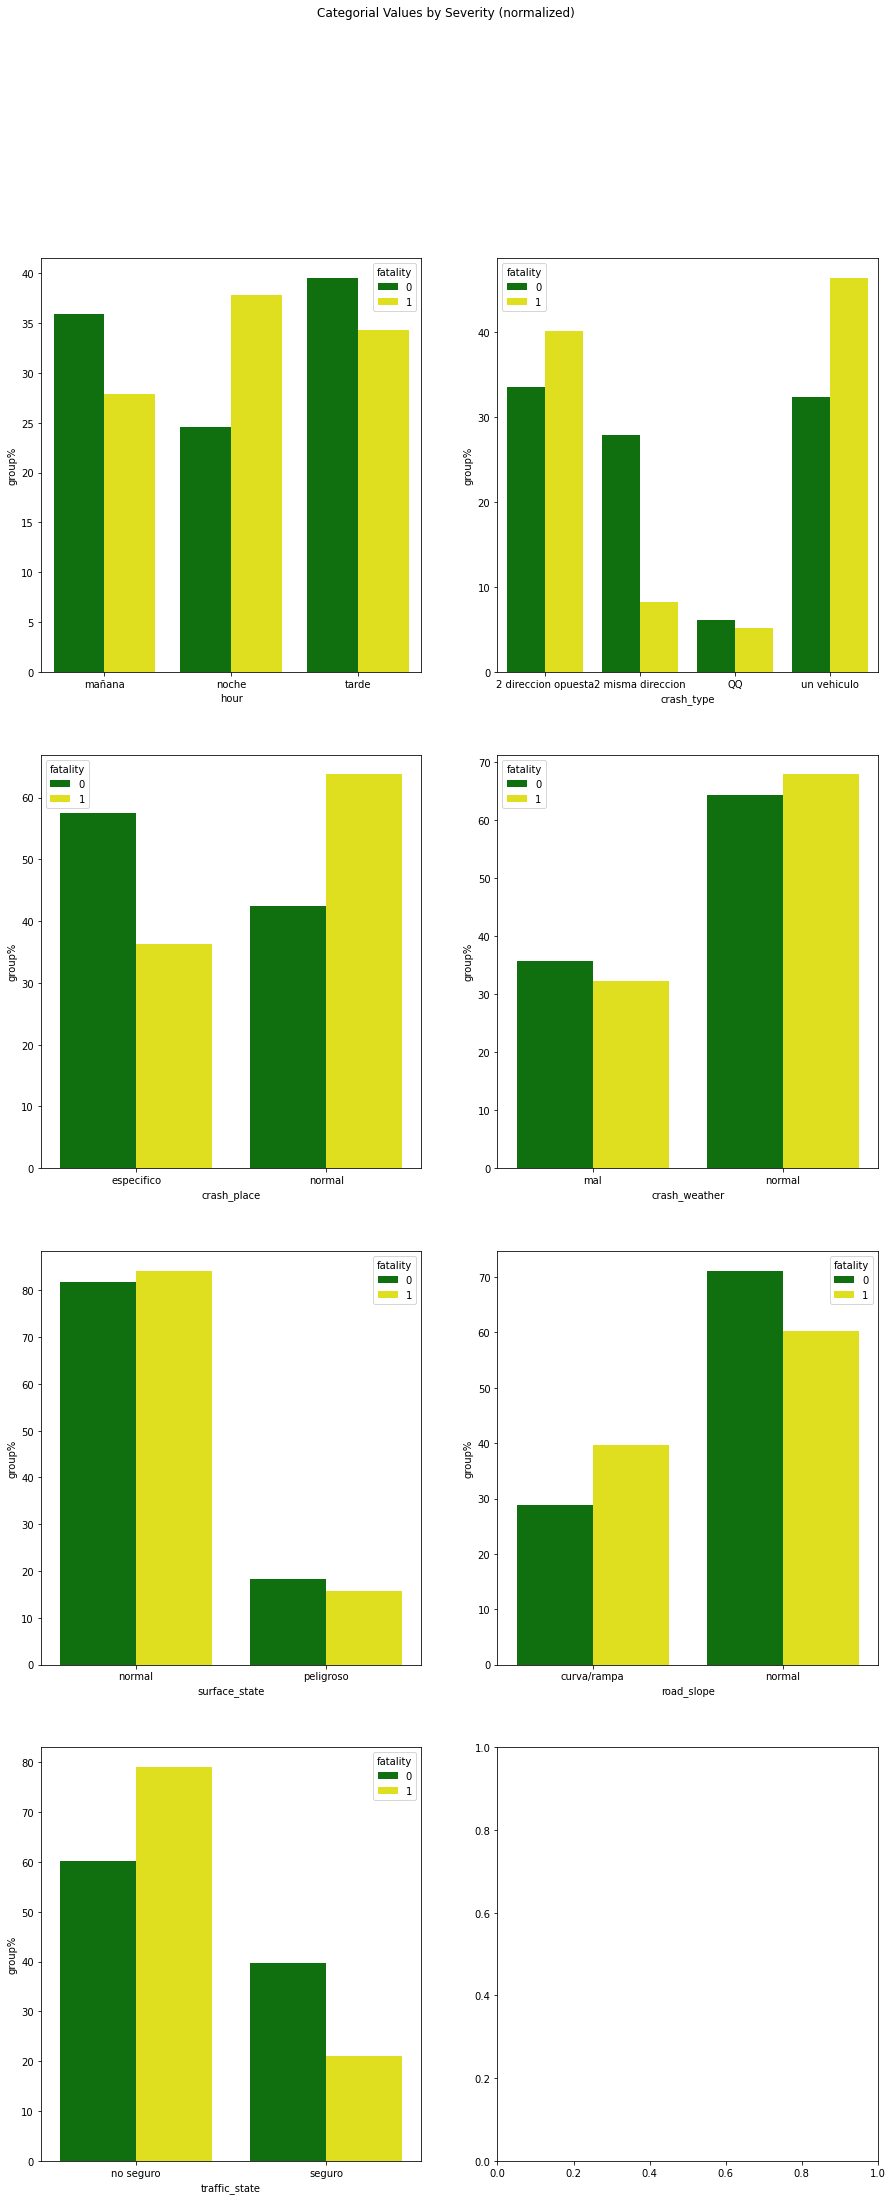

In [199]:
categorical = ["hour", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state"]

fig, axes = plt.subplots(4, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0 # fila del dibujo
j = 0 # columna del dibujo

# Impresión de cada categoría
for cat in categorical:
    # Normalizamos la categoría para que sea visulamente interpretable
    temp = norm_category(df = acc_df, objetivo = 'fatality', categorica = cat)
    # Creamos la gráfica
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'fatality', palette=['green', 'yellow'],ax = axes[i,j]);
    
    # Modificamos los índices de las gráficas para su dibujo
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

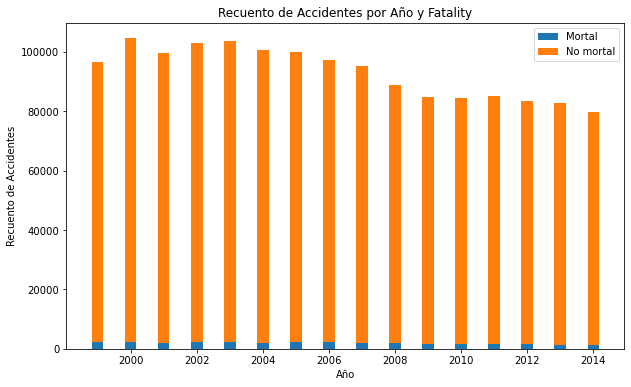

In [201]:
import matplotlib.pyplot as plt

# Agrupar y contar los accidentes por año y fatality
grouped = acc_df.groupby(['year', 'fatality']).size().unstack()

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Configurar los datos y etiquetas para cada barra
bar_width = 0.35
x = grouped.index
y1 = grouped[1].fillna(0)
y0 = grouped[0].fillna(0)

# Dibujar las barras para fatality=1
ax.bar(x, y1, width=bar_width, label='Mortal')

# Dibujar las barras para fatality=0
ax.bar(x, y0, width=bar_width, bottom=y1, label='No mortal')

# Configurar los ejes y etiquetas
ax.set_xlabel('Año')
ax.set_ylabel('Recuento de Accidentes')
ax.set_title('Recuento de Accidentes por Año y Fatality')
ax.legend()

# Mostrar el gráfico
plt.show()


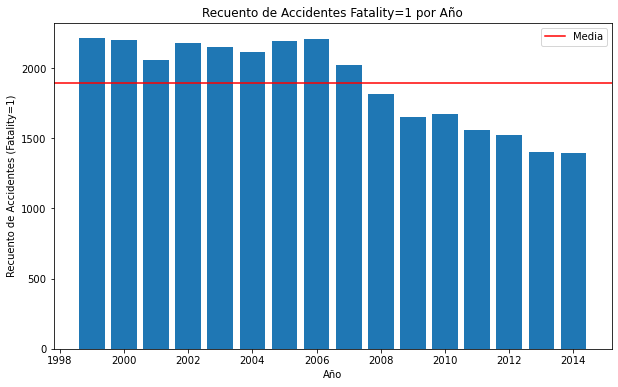

In [217]:
import matplotlib.pyplot as plt

# Filtrar el dataframe para incluir únicamente los casos con fatality = 1
filtered_df = acc_df[acc_df['fatality'] == 1]

# Agrupar y contar los accidentes por año
grouped = filtered_df.groupby('year').size()

# Calcular la media
mean_value = grouped.mean()

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Configurar los datos y etiquetas para cada barra
x = grouped.index
y = grouped.values

# Dibujar las barras
ax.bar(x, y)

# Dibujar la línea de la media
ax.axhline(mean_value, color='red', linestyle='-', label='Media')

# Configurar los ejes y etiquetas
ax.set_xlabel('Año')
ax.set_ylabel('Recuento de Accidentes (Fatality=1)')
ax.set_title('Recuento de Accidentes Fatality=1 por Año')

# Mostrar la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()



Podemos ver una caida en el numero de accidentes en los ultimos años

# Outliers

<AxesSubplot:xlabel='n_personas_implicadas'>

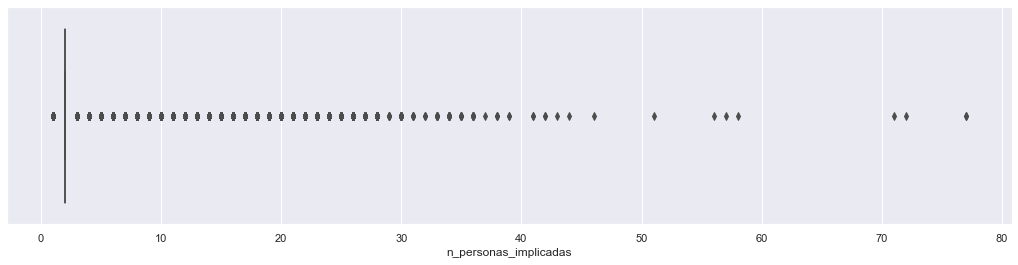

In [224]:
sns.set(rc={'figure.figsize':(18, 4)})
sns.boxplot(acc_df["n_personas_implicadas"])

En la variable numero de personas implicadas en un accidente, podemos apreciar claramente que es mas frecuente tener un numero bajo de implicados en el accidente. Tambien podemos observar que hay accidentes con mas de 70 personas implicadas estos pueden ser accidentes multiples o autobuses.

<AxesSubplot:xlabel='vehicles_involved'>

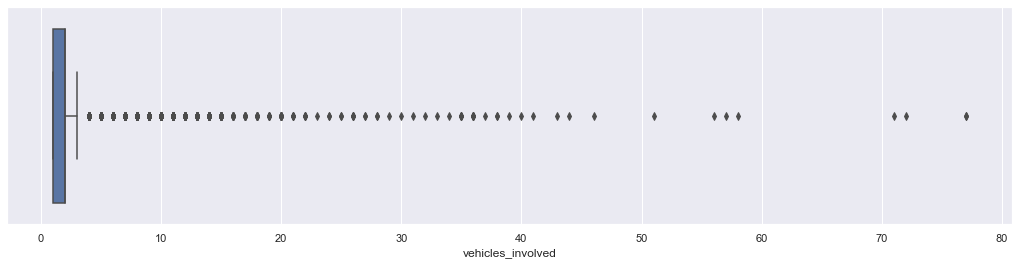

In [225]:
sns.set(rc={'figure.figsize':(18, 4)})
sns.boxplot(acc_df["vehicles_involved"])

# Tranformacion de variables discretas

In [28]:
numeric_var = ['year','month', 'weekday', 'vehicles_involved']
acc_df[numeric_var] = acc_df[numeric_var].astype(float)

In [29]:
for col in acc_df.columns:
    print(col)
    print(acc_df[col].unique())
    print('-------------------------')

year
[1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010.
 2011. 2012. 2013. 2014.]
-------------------------
month
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
-------------------------
weekday
[1. 2. 3. 4. 5. 6. 7.]
-------------------------
hour
['noche' 'mañana' 'tarde']
-------------------------
fatality
[0 1]
-------------------------
vehicles_involved
[ 1.  2.  9.  3.  4.  6.  5.  7.  8. 13. 12. 14. 10. 16. 26. 71. 19. 11.
 21. 27. 35. 15. 41. 22. 46. 25. 31. 18. 56. 23. 17. 36. 20. 29. 38. 77.
 28. 32. 33. 72. 44. 58. 40. 30. 24. 39. 34. 57. 43. 37. 51.]
-------------------------
crash_type
['un vehiculo' '2 misma direccion' '2 direccion opuesta' 'QQ']
-------------------------
crash_place
['normal' 'especifico']
-------------------------
crash_weather
['normal' 'mal']
-------------------------
surface_state
['peligroso' 'normal']
-------------------------
road_slope
['normal' 'curva/rampa']
-------------------------
traffic_state
['no seguro' 'seguro']

# Balanceo variable fatality

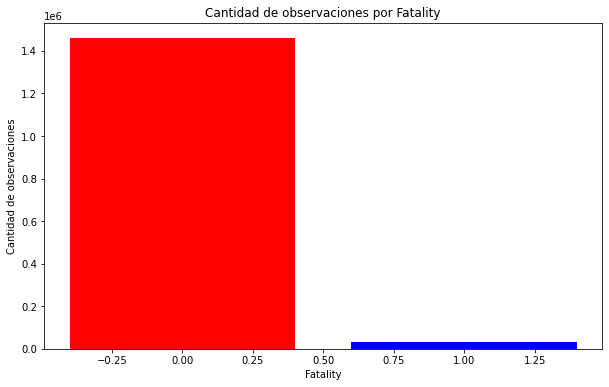

In [30]:
# Plot variable 'fatality'

# Contar la cantidad de observaciones de cada categoría
conteo_fatality = acc_df['fatality'].value_counts()

plt.figure(figsize=(10, 6))  # Tamaño del gráfico (ancho, alto)
plt.bar(conteo_fatality.index, conteo_fatality.values, color=['red', 'blue'])

# Personalizar el gráfico
plt.xlabel('Fatality')
plt.ylabel('Cantidad de observaciones')
plt.title('Cantidad de observaciones por Fatality')

# Mostrar el gráfico
plt.show()


Hay varias formas de balancear esta variable: 
* Submuestreo aleatorio (undersampling): Consiste en reducir la cantidad de muestras de la clase mayoritaria para que sea igual a la cantidad de muestras de la clase minoritaria.

* Sobremuestreo aleatorio (oversampling): Implica aumentar la cantidad de muestras de la clase minoritaria para que sea igual o similar a la cantidad de muestras de la clase mayoritaria. Esto se puede hacer replicando muestras existentes o generando muestras sintéticas.

* Técnicas de combinación (combination sampling): Estas técnicas combinan submuestreo y sobremuestreo para equilibrar las clases. Algunos ejemplos son SMOTE (Synthetic Minority Over-sampling Technique) y ADASYN (Adaptive Synthetic Sampling).

In [31]:
from imblearn.over_sampling import RandomOverSampler

# Supongamos que tienes el DataFrame acc_df con una columna llamada "fatality"

# Contar la cantidad de muestras en cada clase
conteo_clases = acc_df['fatality'].value_counts()

# Obtener la clase mayoritaria y minoritaria
clase_mayoritaria = conteo_clases.idxmax()
clase_minoritaria = conteo_clases.idxmin()

# Aplicar sobremuestreo aleatorio
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(acc_df.drop('fatality', axis=1), acc_df['fatality'])

# Crear un nuevo DataFrame balanceado
acc_df_balanceado = pd.DataFrame(X_resampled, columns=acc_df.columns.drop('fatality'))
acc_df_balanceado['fatality'] = y_resampled

# Verificar el balanceo
conteo_clases_balanceado = acc_df_balanceado['fatality'].value_counts()
print(conteo_clases_balanceado)


0    1459425
1    1459425
Name: fatality, dtype: int64


# Codificacion de variables

## Label Encoder binario

El Binary Encoding asigna un número binario (0 o 1) único a cada categoría. Por ejemplo, si tienes una variable categórica "crash_place" con las categorías "especifico" y "normal", el Binary Encoding podría asignar "0" para "especifico" y "1" para "normal".

In [32]:
labelCat = ['hour', 'crash_type','crash_place', 'crash_weather', 'surface_state', 'traffic_state', 'road_slope']
lb = preprocessing.LabelEncoder()
for cat in labelCat:
    acc_df_balanceado[cat] = lb.fit_transform(acc_df_balanceado[cat])
    print(lb.classes_)

['mañana' 'noche' 'tarde']
['2 direccion opuesta' '2 misma direccion' 'QQ' 'un vehiculo']
['especifico' 'normal']
['mal' 'normal']
['normal' 'peligroso']
['no seguro' 'seguro']
['curva/rampa' 'normal']


In [34]:
acc_df_balanceado.head()

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,n_personas_implicadas,fatality
0,1999.0,1.0,1.0,1,1.0,3,1,1,1,1,0,1,0
1,1999.0,1.0,1.0,1,1.0,3,1,1,1,1,0,1,0
2,1999.0,1.0,1.0,1,1.0,3,1,0,0,1,0,1,0
3,1999.0,1.0,1.0,1,1.0,3,1,0,1,0,0,2,0
4,1999.0,1.0,1.0,1,1.0,3,1,0,1,0,0,1,0


# Seleccion de variables 

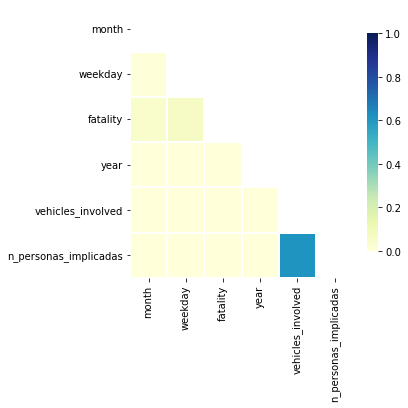

In [35]:
# Compute the correlation matrix
corr = np.abs(acc_df_balanceado[['month','weekday','fatality', 'year', 'vehicles_involved', 'n_personas_implicadas']]).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos que no existe una gran correlacion entre las variables y la variable objectivo. Sin embargo, las variables n_personas_implicadas y vehicles_involved muestran una alta correlación. Esta es normal teniendo en cuenta que el número de vehículos involucrados tienen una relación con las personas involucradas al ser estas usuarios de estos vehículos.  Su correlación tampoco es muy elevada como para ser eliminadas.

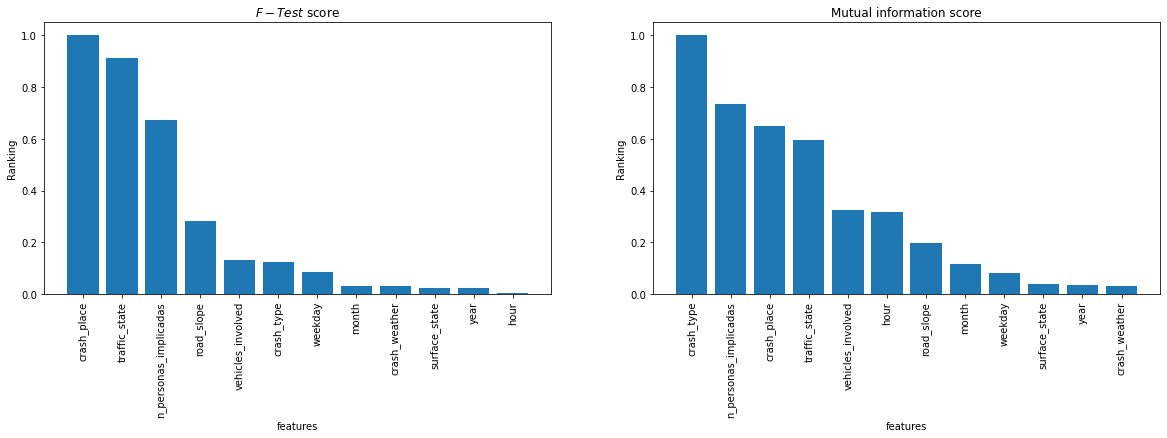

In [36]:
feature_names = acc_df_balanceado.columns[:-1]

y = acc_df_balanceado['fatality']  # Nos quedamos con la columna 'fatality'
X = acc_df_balanceado.drop('fatality', axis=1)  # Eliminamos la columna 'fatality' del DataFrame

# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# Obtener los índices ordenados de mayor a menor
f_test_indices = np.argsort(f_test)[::-1]
mi_indices = np.argsort(mi)[::-1]

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test[f_test_indices],  align="center")
plt.xticks(range(X.shape[1]),feature_names[f_test_indices], rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi[mi_indices], align="center")
plt.xticks(range(X.shape[1]),feature_names[mi_indices], rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vamos a quitar las variables 'year', 'crash_weather', 'suface_state' que son las que menor informacion mutua tienen.

In [58]:
prueba = acc_df_balanceado.drop(['year', 'crash_weather', 'surface_state'], axis=1)
X = prueba.drop("fatality", axis=1)
Y = prueba["fatality"]

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.30, random_state=250)

# Particion train y test

Realizamos una particion del conjunto de datos en train (70% de los datos) para entrenar los diferentes modelos.

In [37]:
X = acc_df_balanceado.drop("fatality", axis=1)
Y = acc_df_balanceado["fatality"]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.30, random_state=250)

# Modelos 

Los modelos que vamos a ver son los siguientes :
* Regresion Logística
* Árbol de decisión
* Bagging
* Gradient Boosting
* XGBoost

Observacion: con un dataset desbalanceado, no debemos guiarnos por el accuracy de los modelos a la hora de compararlos (porque favorecen a la clase mayoritaria), sino más por la matriz de confusión normalizada y la curva ROC.

In [156]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_confusion_matrix(y_true, y_pred):
    # Calcular la matriz de confusión
    confusion = confusion_matrix(y_true, y_pred)

    # Calcular la suma de cada fila
    row_sums = confusion.sum(axis=1)

    # Dividir cada valor en la matriz por la suma de su fila
    normalized_confusion = confusion / row_sums[:, np.newaxis]

    # Visualizar la matriz de confusión normalizada
    plt.figure(figsize=(4, 4))
    sns.heatmap(normalized_confusion, annot=True, cmap="Blues", cbar=False,
                annot_kws={"fontsize": 12}, linewidths=0.5, square=True)
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.show()


In [184]:
predictions = {}
models={}

## Regresion Logistica

In [158]:
# Crear un objeto de regresión lineal
regressor = LogisticRegression()

# Entrenar el modelo utilizando el conjunto de entrenamiento
regressor.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = regressor.predict(x_test)
predictions['Log_Reg']=y_pred

# Exactitud (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud:", accuracy)

# Precisión (Precision)
precision = precision_score(y_test, y_pred)
print("Precisión:", precision)

# Sensibilidad (Recall o Sensitivity)
recall = recall_score(y_test, y_pred)
print("Exhaustividad:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("Puntuación F1:", f1)

metricas_RL = [accuracy,precision,recall,f1]

Exactitud: 0.6295949888940279
Precisión: 0.6184125950598115
Exhaustividad: 0.6768107037711242
Puntuación F1: 0.6462951431790002


In [159]:
# Obtener las probabilidades de predicción para la clase positiva
pred_prob = regressor.predict_proba(x_test)[:, 1]

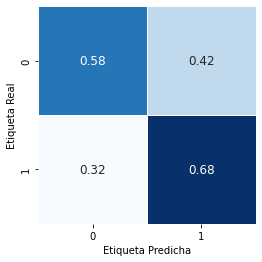

In [160]:
plot_normalized_confusion_matrix(y_test,y_pred)

Interpretacion: Predice el 68% de los accidentes mortales bien y de los no mortales el 58%. Veamos si con el resto de modelos podemos mejorarlo.

In [161]:
# Aplicar la condición y asignar valores de 0 o 1
new_pred_prob = np.where(pred_prob < 0.5, 0, 1)

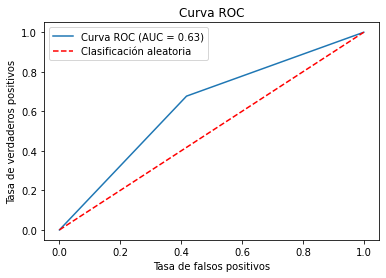

In [162]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, new_pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, new_pred_prob)
metricas_RL.append(auc)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Clasificación aleatoria')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


## Arbol de decision

In [163]:
# Crear un objeto de árbol de decisión
tree_clf = DecisionTreeClassifier()

# Entrenar el modelo utilizando el conjunto de entrenamiento
tree_clf.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = tree_clf.predict(x_test)
predictions['Decision_Tree']=y_pred

# Exactitud (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud:", accuracy)

# Precisión (Precision)
precision = precision_score(y_test, y_pred)
print("Precisión:", precision)

# Sensibilidad (Recall o Sensitivity)
recall = recall_score(y_test, y_pred)
print("Exhaustividad:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("Puntuación F1:", f1)

metricas_arbol = [accuracy, precision, recall, f1]

Exactitud: 0.7472954531179518
Precisión: 0.7123019335559507
Exhaustividad: 0.8297089946485713
Puntuación F1: 0.7665358401384229


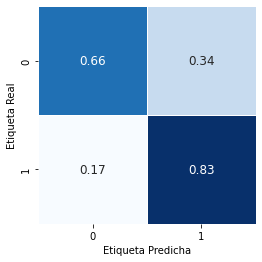

In [164]:
# Llamar a la función con los valores de y_test y y_pred
plot_normalized_confusion_matrix(y_test, y_pred)

Mejora bastante respecto a la prediccion de accidentes mortales. Sin embargo, todavia sigue prediciendo peor los accidentes que no lo son.

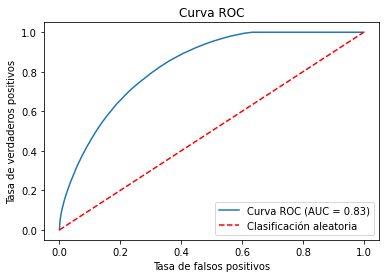

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de predicción para la clase positiva
pred_prob = tree_clf.predict_proba(x_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, pred_prob)
metricas_arbol.append(auc)
# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Clasificación aleatoria')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


Mejora mucho la curva ROC y el AUC por lo que este modelo parece ser mejor que regresion logistica.

## Modelo Bagging

El proceso de Bagging comienza dividiendo el conjunto de datos de entrenamiento en múltiples subconjuntos aleatorios, a menudo llamados "subconjuntos de bootstrap". Se entrena un modelo base en cada subconjunto de bootstrap, lo que resulta en múltiples modelos base. Estos modelos se utilizan para hacer predicciones en el conjunto de datos de prueba.

La idea detrás del Bagging es que los modelos base pueden tener diferentes fortalezas y debilidades debido a las diferentes muestras de entrenamiento. Al combinar estas predicciones, se pueden cancelar los errores y se puede mejorar la precisión general del modelo.

In [166]:
# Crear un clasificador base (en este caso, un árbol de decisión)
base_classifier = DecisionTreeClassifier()

# Crear un clasificador Bagging
bagging_classifier = BaggingClassifier(base_estimator=base_classifier)

# Entrenar el clasificador Bagging utilizando el conjunto de entrenamiento
bagging_classifier.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = bagging_classifier.predict(x_test)
predictions['Bagging'] = y_pred

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Guardar las métricas en una lista
metricas_bagging = [accuracy, precision, recall, f1]


Accuracy: 0.7472760390793177
Precision: 0.7120295804217717
Recall: 0.8303919127874708
F1 Score: 0.7666693025879475


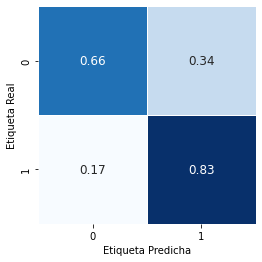

In [167]:
# Llamar a la función con los valores de y_test y y_pred
plot_normalized_confusion_matrix(y_test, y_pred)

Interpretacion: Predice el 83% de los accidentes mortales bien y de los no mortales el 66%. Esta bastante bien, sobretodo porque estamos interesados en predecir los accidentes mortales.

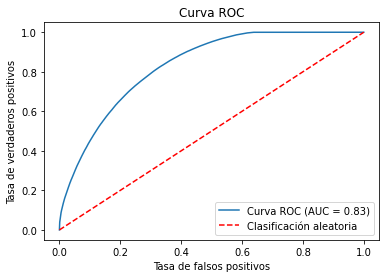

In [178]:
# Obtener las probabilidades de predicción para la clase positiva
pred_prob = bagging_classifier.predict_proba(x_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, pred_prob)
metricas_bagging.append(auc)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Clasificación aleatoria')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Modelo Gradient Boosting

In [169]:
# Crear un clasificador Gradient Boosting
gb_classifier = GradientBoostingClassifier()

# Entrenar el clasificador utilizando el conjunto de entrenamiento
gb_classifier.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = gb_classifier.predict(x_test)
predictions['Gradient_Boosting'] = y_pred

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Guardar las métricas en una lista
metricas_gradient_boosting = [accuracy, precision, recall, f1]

Accuracy: 0.6707481827888837
Precision: 0.662453822417315
Recall: 0.6962750127333399
F1 Score: 0.6789434826231866


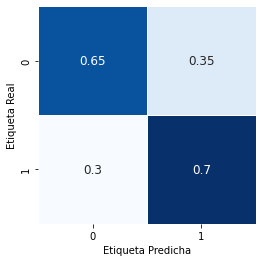

In [170]:
# Llamar a la función con los valores de y_test y y_pred
plot_normalized_confusion_matrix(y_test, y_pred)

Interpretacion: Predice el 70% de los accidentes mortales bien y de los no mortales el 65%. Ha empeorado.

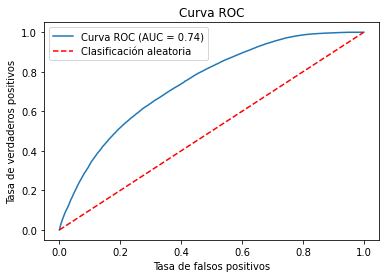

In [171]:
# Obtener las probabilidades de predicción para la clase positiva
pred_prob = gb_classifier.predict_proba(x_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, pred_prob)
metricas_gradient_boosting.append(auc)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Clasificación aleatoria')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


## Modelo XGBOOST

In [172]:
# Crear un objeto de clasificador XGBoost
xgb_classifier = xgb.XGBClassifier()

# Entrenar el modelo utilizando el conjunto de entrenamiento
xgb_classifier.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = xgb_classifier.predict(x_test)
predictions['XGB']=y_pred

# Exactitud (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud:", accuracy)

# Precisión (Precision)
precision = precision_score(y_test, y_pred)
print("Precisión:", precision)

# Sensibilidad (Recall o Sensitivity)
recall = recall_score(y_test, y_pred)
print("Exhaustividad:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("Puntuación F1:", f1)

metricas_xgb = [accuracy, precision, recall, f1]

Exactitud: 0.6912425555726855
Precisión: 0.6790394040216564
Exhaustividad: 0.7253207317045317
Puntuación F1: 0.7014174567501753


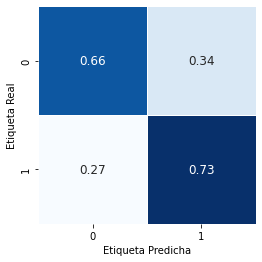

In [173]:
# Llamar a la función con los valores de y_test y y_pred
plot_normalized_confusion_matrix(y_test, y_pred)

Interpretacion: Predice el 73% de los accidentes mortales bien y de los no mortales el 66%. Mejora con respecto al anterior.

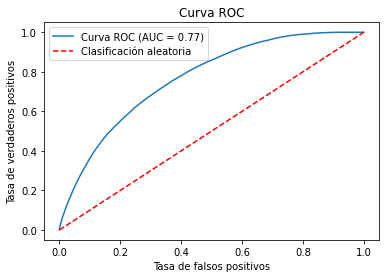

In [174]:
# Obtener las probabilidades de predicción para la clase positiva
pred_prob = xgb_classifier.predict_proba(x_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, pred_prob)
metricas_xgb.append(auc)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Clasificación aleatoria')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


# Evaluacion resultados

A continuación, procedemos a valorar los modelos de forma conjunta, para poder escoger el mejor modelo.

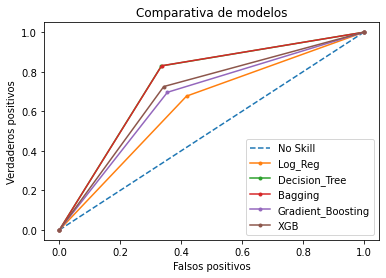

In [176]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in predictions:
    # calculate roc curves (no prob)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[key])
    plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Comparativa de modelos')
plt.legend()

In [186]:
models['LogisticRegression']= regressor
models['DecisionTree']=tree_clf
models['Bagging']= bagging_classifier
models['GradientBoosting']= gb_classifier
models['XGBoost']= xgb_classifier

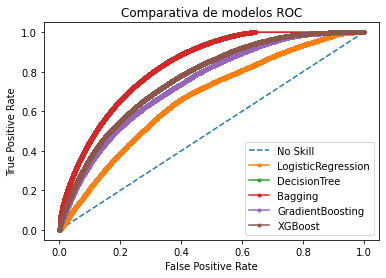

In [190]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in models:
        yhat = models[key].predict_proba(x_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa de modelos ROC')
plt.legend()

En la curva ROC un clasificador ideal tendría una tasa de verdaderos positivos del 100% y una tasa de falsos positivos del 0%, lo que se traduciría en un área bajo la curva (AUC) de 1. Cuanto más se acerque la curva ROC a la esquina superior izquierda del gráfico, mejor será el rendimiento del modelo.
En nuestro caso los clasificadores Bagging y arbol de decision son los que mejor resultados proporcionan para esta métrica.

In [179]:
# Hacemos un dataframe que recoja todas las metricas para cada modelo.

# Crear un diccionario con las métricas de cada modelo
metricas = {
    "Regresion Logistica": metricas_RL,
    "Gradient boosting":metricas_gradient_boosting,
    "Arbol de decision": metricas_arbol,
    "Bagging": metricas_bagging, 
    "XGBoost": metricas_xgb
}

# Crear el dataframe
df_metricas = pd.DataFrame(metricas, index=["accuracy", "precision", "recall", "f1","auc"])

# Transponer el dataframe
df_metricas = df_metricas.T

# Renombrar la columna del índice a "nombre_modelo"
df_metricas.index.name = "nombre_modelo"

df_metricas

,accuracy,precision,recall,f1,auc
nombre_modelo,,,,,
Regresion Logistica,0.629595,0.618413,0.676811,0.646295,0.629595
Gradient boosting,0.670748,0.662454,0.696275,0.678943,0.742774
Arbol de decision,0.747295,0.712302,0.829709,0.766536,0.830568
Bagging,0.747276,0.712030,0.830392,0.766669,0.830882
XGBoost,0.691243,0.679039,0.725321,0.701417,0.766131


La tabla anterior imprime los resultados de las métricas para cada modelo. Como ya hemos dicho, utilizaremos recall y el AUC como la métrica principal. 

El recall proporciona información sobre la capacidad del modelo para capturar los casos positivos reales y es especialmente útil cuando la detección de casos positivos es una prioridad, como en problemas de detección de accidentes mortales.

$$Recall = \frac{Verdaderos\ Positivos}{Verdaderos\ Positivos + Falsos\ Negativos}$$

Por otro lado, la Curva ROC (Receiver Operating Characteristic) es una representación gráfica del rendimiento de un modelo de clasificación binaria. El AUC es el área que se encuentra debajo de esta curva. Proporciona una medida del rendimiento general del modelo al evaluar su capacidad para distinguir entre clases positivas y negativas. Un valor del AUC cercano a 1 indica un modelo muy bueno y un valor de 0.5 indica un rendimiento aleatorio.

Con esto, los modelos que mayor AUC proporcionan son el arbol de decision y el bagging.
